In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Data preparation

In [4]:
train_path  = 'dataset/train'
valid_path  = 'dataset/valid'
test_path  = 'dataset/test'

In [5]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 51 images belonging to 10 classes.


### 3. VGG16 base model pre-trained on ImageNet dataset

In [6]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 2. freeze the classification layers in the base model

In [8]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [9]:
last_layer = base_model.get_layer('global_average_pooling2d')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)

new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 10)                  │           5,1

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 7,084,554 (27.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [10]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

4. Test without training : 

In [ ]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

### 4. Train the new model

In [12]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.keras', save_best_only=True)

history = new_model.fit(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])

C:\Users\PaulE\DeepLearning\local\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1109 - loss: 6.8001 - val_accuracy: 0.2111 - val_loss: 2.2431
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1808 - loss: 2.2153 - val_accuracy: 0.2000 - val_loss: 2.0485
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2300 - loss: 1.9998 - val_accuracy: 0.3778 - val_loss: 1.7288
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4409 - loss: 1.6569 - val_accuracy: 0.5778 - val_loss: 1.2632
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5580 - loss: 1.3070 - val_accuracy: 0.6444 - val_loss: 1.0173
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7076 - loss: 0.9226 - val_accuracy: 0.7444 - val_loss: 0.7165
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7751 - loss: 0.5823 - val_accuracy: 0.8444 - val_loss: 0.4985
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8663 - loss: 0.4414 - val_accuracy: 0.9667 - val_loss:

C:\Users\PaulE\DeepLearning\local\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9136 - loss: 0.2706 - val_accuracy: 0.9111 - val_loss: 0.3406
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9403 - loss: 0.2073 - val_accuracy: 0.8889 - val_loss: 0.2780
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9385 - loss: 0.1770 - val_accuracy: 0.9444 - val_loss: 0.1465
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9910 - loss: 0.1077 - val_accuracy: 0.9556 - val_loss: 0.1454
Epoch 14/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9853 - loss: 0.0600 - val_accuracy: 0.9778 - val_loss: 0.0880
Epoch 15/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9827 - loss: 0.0607 - val_accuracy: 0.8889 - val_loss: 0.4107
Epoch 16/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9460 - loss: 0.1342 - val_accuracy: 0.9778 - val_loss: 0.0742
Epoch 17/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9606 - loss: 0.0965 - val_accuracy: 0.9222 - val_loss: 0.2

In [13]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0206
Test Loss: 0.020630495622754097
Test Accuracy: 1.0


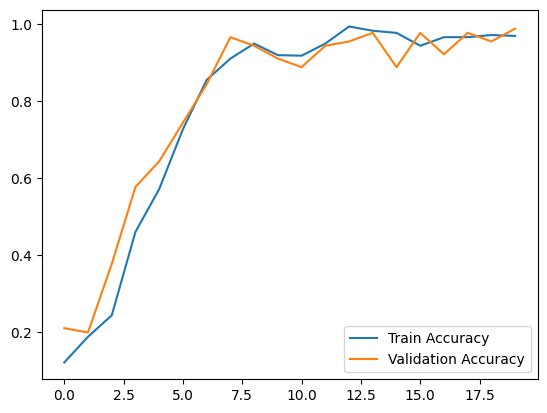

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

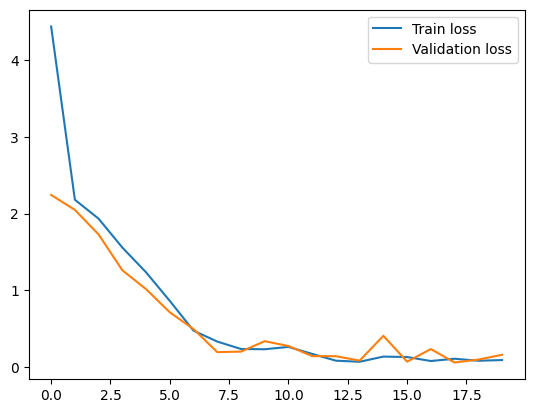

In [15]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()